In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import sampler
from torch.utils.data import DataLoader

import torchvision.datasets as dset
import torchvision.transforms as T

import timeit

import models
import solver
import views

In [3]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

print_every = 100

def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
    
    
def show_solver_training(solver):
    views.show_traning(solver.loss_history, solver.train_acc_history, solver.val_acc_history)

    
def show_mean_and_std_hist(parameters):
    paras = [w.data.cpu().numpy() for w in parameters]
    views.plot_mean_std_hist(paras)

    
def show_conv_layer_weights(conv_weights):
    conv_weights = conv_weights.data.cpu().numpy()
    conv_weights = conv_weights.transpose(0, 2, 3, 1)
    views.show_conv_weights(conv_weights)

    
def compare_solvers_tranings(solvers_with_labels):
    loss_train_val_acc_with_labels = {}
    for label, solver in solvers_with_labels.items():
        loss_train_val_acc_with_labels[label] = (solver.loss_history, solver.train_acc_history, solver.val_acc_history)
    
    views.compare_trainings(loss_train_val_acc_with_labels)

# Load cifar-10 dataset


In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset.
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from"""
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples
    
NUM_TRAIN = 49000
NUM_VAL = 1000

NUM_TRAIN_SMALL = 64

cifar10_train_small = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train_small = DataLoader(cifar10_train_small, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_train = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

cifar10_val = dset.CIFAR10('../cs231n/datasets/', train=True, download=True, transform=T.ToTensor())
# cifar10_val = cifar10_train # can do this?
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('../cs231n/datasets/', train=False, download=True, transform=T.ToTensor())
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# 1. train first model

In [5]:
torch.cuda.random.manual_seed(12345)

example_default_lr = 3e-4
example_default_reg = 8e-3
example_default_scheduler_step_size = 5
example_default_scheduler_gamma = 0.6

default_num_filters = 32

example_model = models.ExampleDifferentFiltersNet(num_filters=default_num_filters).type(dtype)
example_loss_fn = nn.CrossEntropyLoss().type(dtype)

example_optimizer = optim.SGD(example_model.parameters(), lr=example_default_lr, momentum=0.9, weight_decay=example_default_reg)
example_exp_lr_scheduler = lr_scheduler.StepLR(example_optimizer,
                                               step_size=example_default_scheduler_step_size,
                                               gamma=example_default_scheduler_gamma)

example_solver = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=example_model,
                                     loss_fn=example_loss_fn,
                                     optimizer=example_optimizer,
                                     scheduler=example_exp_lr_scheduler,
                                     dtype=dtype,
                                     num_epochs=20, verbose=True)

example_solver.train()

t = 0, loss = 2.3024
t = 100, loss = 1.9372
t = 200, loss = 1.6658
t = 300, loss = 1.8311
t = 400, loss = 1.7289
t = 500, loss = 1.7232
t = 600, loss = 1.6665
t = 700, loss = 1.5159
(Epoch 0 / 20) train acc: 0.486328; val acc: 0.488000
t = 0, loss = 1.5599
t = 100, loss = 1.4828
t = 200, loss = 1.2257
t = 300, loss = 1.4631
t = 400, loss = 1.3023
t = 500, loss = 1.5321
t = 600, loss = 1.4370
t = 700, loss = 1.3360
(Epoch 1 / 20) train acc: 0.539062; val acc: 0.535000
t = 0, loss = 1.3712
t = 100, loss = 1.3678
t = 200, loss = 1.0910
t = 300, loss = 1.2963
t = 400, loss = 1.1539
t = 500, loss = 1.4111
t = 600, loss = 1.3063
t = 700, loss = 1.2497
(Epoch 2 / 20) train acc: 0.578125; val acc: 0.572000
t = 0, loss = 1.2469
t = 100, loss = 1.2787
t = 200, loss = 1.0125
t = 300, loss = 1.1526
t = 400, loss = 1.0440
t = 500, loss = 1.3938
t = 600, loss = 1.2278
t = 700, loss = 1.1876
(Epoch 3 / 20) train acc: 0.589844; val acc: 0.581000
t = 0, loss = 1.1385
t = 100, loss = 1.1839
t = 200, los

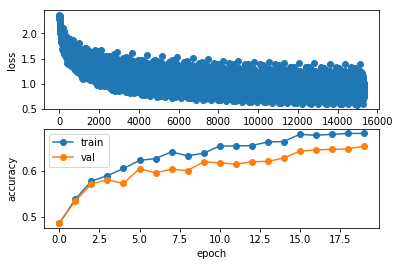

In [6]:
show_solver_training(example_solver)

In [12]:
#lr1 = example_default_lr
#reg1 = example_default_reg
#step_size1 = example_default_scheduler_step_size
#gamma1 = example_default_scheduler_gamma

lr1 = 1e-2
reg1 = 1e-6
step_size1 = example_default_scheduler_step_size
gamma1 = example_default_scheduler_gamma

num_filters1 = 64
num_epochs1 = 5

model1 = models.ExampleDifferentFiltersNet(num_filters=num_filters1).type(dtype)
loss_fn1 = nn.CrossEntropyLoss().type(dtype)

optimizer1 = optim.SGD(model1.parameters(), lr=lr1, momentum=0.9, weight_decay=reg1)
lr_scheduler1 = None
#lr_scheduler1 = lr_scheduler.StepLR(optimizer, step_size=step_size1, gamma=gamma1)

solver1 = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=model1,
                                     loss_fn=loss_fn1,
                                     optimizer=optimizer1,
                                     scheduler=lr_scheduler1,
                                     dtype=dtype,
                                     num_epochs=num_epochs1, verbose=True)

solver1.train()

t = 0, loss = 2.3346
t = 100, loss = 1.7257
t = 200, loss = 1.3029
t = 300, loss = 1.5210
t = 400, loss = 1.6768
t = 500, loss = 1.7032
t = 600, loss = 1.5693
t = 700, loss = 1.4707
(Epoch 0 / 5) train acc: 0.494141; val acc: 0.475000
t = 0, loss = 1.5343
t = 100, loss = 1.4668
t = 200, loss = 1.1494
t = 300, loss = 1.5521
t = 400, loss = 1.4704
t = 500, loss = 1.7195
t = 600, loss = 1.3894
t = 700, loss = 1.3558
(Epoch 1 / 5) train acc: 0.480469; val acc: 0.465000
t = 0, loss = 1.2693
t = 100, loss = 1.5060
t = 200, loss = 1.0886
t = 300, loss = 1.3894
t = 400, loss = 1.4989
t = 500, loss = 1.6836
t = 600, loss = 1.2455
t = 700, loss = 1.4545
(Epoch 2 / 5) train acc: 0.526367; val acc: 0.512000
t = 0, loss = 1.2764
t = 100, loss = 1.4021
t = 200, loss = 1.0404
t = 300, loss = 1.4018
t = 400, loss = 1.4564
t = 500, loss = 1.4777
t = 600, loss = 1.3418
t = 700, loss = 1.3786
(Epoch 3 / 5) train acc: 0.529297; val acc: 0.522000
t = 0, loss = 1.1533
t = 100, loss = 1.3780
t = 200, loss = 

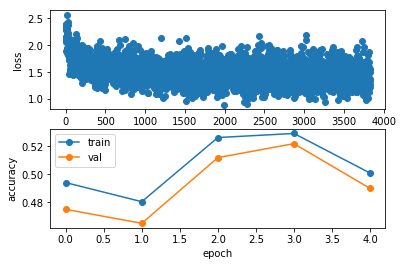

In [13]:
show_solver_training(solver1)

In [19]:
# cross validation
# fixed filter number
import numpy as np

train_stats = {}

num_filters1 = 64
model1 = models.ExampleDifferentFiltersNet(num_filters=num_filters1).type(dtype)
loss_fn1 = nn.CrossEntropyLoss().type(dtype)

max_count = 1
for count in range(max_count):
    #lr1 = 10**np.random.uniform(-4, -3)
    #lr1 = 1e-4 * np.random.uniform(1, 6)
    lr1 = 1e-3*np.random.uniform(1, 5)
    #reg1 = 10**np.random.uniform(-6, -2)
    reg1 = 1e-6
    epochs1 = 40
    step_size1 = 5
    gamma1 = 0.5
    
    model1.apply(reset)
    optimizer1 = optim.SGD(model1.parameters(), lr=lr1, momentum=0.9, weight_decay=reg1)

    #lr_scheduler1 = None
    lr_scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=step_size1, gamma=gamma1)

    
    solver1 = solver.ClassificationSolver(loader_train=loader_train, loader_val=loader_val,
                                     model=model1,
                                     loss_fn=loss_fn1,
                                     optimizer=optimizer1,
                                     scheduler=lr_scheduler1,
                                     dtype=dtype,
                                     num_epochs=epochs1, verbose=True)

    solver1.train()
    
    #show_solver_training(solver1)
    
    train_stats[(lr1, reg1)] = (solver1.train_acc_history, solver1.val_acc_history, solver1.loss_history)
    print('val accuracy: %f, train accuracy: %f, final loss: %f, lr: %e, reg: %e' % (
        solver1.val_acc_history[-1], solver1.train_acc_history[-1], solver1.loss_history[-1], lr1, reg1))

t = 0, loss = 2.3371
t = 100, loss = 1.6184
t = 200, loss = 1.1397
t = 300, loss = 1.3240
t = 400, loss = 1.2642
t = 500, loss = 1.5431
t = 600, loss = 1.3032
t = 700, loss = 1.1736
(Epoch 0 / 40) train acc: 0.581055; val acc: 0.563000
t = 0, loss = 1.2544
t = 100, loss = 1.2013
t = 200, loss = 0.8619
t = 300, loss = 1.1984
t = 400, loss = 1.0922
t = 500, loss = 1.3676
t = 600, loss = 1.0116
t = 700, loss = 1.0988
(Epoch 1 / 40) train acc: 0.557617; val acc: 0.517000
t = 0, loss = 1.0499
t = 100, loss = 0.9887
t = 200, loss = 0.7796
t = 300, loss = 1.0448
t = 400, loss = 0.9471
t = 500, loss = 1.2494
t = 600, loss = 0.9059
t = 700, loss = 1.0061
(Epoch 2 / 40) train acc: 0.623047; val acc: 0.597000
t = 0, loss = 0.9603
t = 100, loss = 0.8930
t = 200, loss = 0.7210
t = 300, loss = 0.9391
t = 400, loss = 0.9165
t = 500, loss = 1.1931
t = 600, loss = 0.8441
t = 700, loss = 0.9628
(Epoch 3 / 40) train acc: 0.621094; val acc: 0.593000
t = 0, loss = 0.9263
t = 100, loss = 0.7994
t = 200, los

t = 700, loss = 0.5304
(Epoch 34 / 40) train acc: 0.850586; val acc: 0.683000
t = 0, loss = 0.3942
t = 100, loss = 0.4775
t = 200, loss = 0.4301
t = 300, loss = 0.3886
t = 400, loss = 0.3378
t = 500, loss = 0.4688
t = 600, loss = 0.3191
t = 700, loss = 0.5206
(Epoch 35 / 40) train acc: 0.846680; val acc: 0.678000
t = 0, loss = 0.3970
t = 100, loss = 0.4729
t = 200, loss = 0.4257
t = 300, loss = 0.3854
t = 400, loss = 0.3368
t = 500, loss = 0.4680
t = 600, loss = 0.3191
t = 700, loss = 0.5204
(Epoch 36 / 40) train acc: 0.846680; val acc: 0.678000
t = 0, loss = 0.3974
t = 100, loss = 0.4713
t = 200, loss = 0.4243
t = 300, loss = 0.3839
t = 400, loss = 0.3360
t = 500, loss = 0.4674
t = 600, loss = 0.3188
t = 700, loss = 0.5197
(Epoch 37 / 40) train acc: 0.847656; val acc: 0.678000
t = 0, loss = 0.3967
t = 100, loss = 0.4706
t = 200, loss = 0.4233
t = 300, loss = 0.3825
t = 400, loss = 0.3352
t = 500, loss = 0.4668
t = 600, loss = 0.3185
t = 700, loss = 0.5190
(Epoch 38 / 40) train acc: 0.

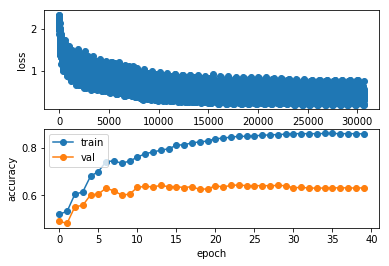

In [18]:
show_solver_training(solver1)

num_filters1 = 64
model1 = models.ExampleDifferentFiltersNet(num_filters=num_filters1).type(dtype)
loss_fn1 = nn.CrossEntropyLoss().type(dtype)

max_count = 20
for count in range(max_count):
    lr1 = 10**np.random.uniform(-5, -2)
    reg1 = 10**np.random.uniform(-6, -2)
    epochs1 = 5

val accuracy: 0.638000, train accuracy: 0.670898, final loss: 0.802312, lr: 4.067673e-04, reg: 2.646316e-04
val accuracy: 0.636000, train accuracy: 0.682617, final loss: 0.964235, lr: 3.785149e-04, reg: 1.996999e-04
val accuracy: 0.638000, train accuracy: 0.670898, final loss: 0.802312, lr: 4.067673e-04, reg: 2.646316e-04
val accuracy: 0.632000, train accuracy: 0.693359, final loss: 0.744556, lr: 9.005739e-04, reg: 1.207946e-04
val accuracy: 0.623000, train accuracy: 0.685547, final loss: 0.671807, lr: 2.871313e-03, reg: 1.580534e-05
val accuracy: 0.623000, train accuracy: 0.689453, final loss: 0.681413, lr: 2.464492e-03, reg: 1.021501e-03
val accuracy: 0.622000, train accuracy: 0.667969, final loss: 0.676962, lr: 2.170896e-03, reg: 9.537196e-06
val accuracy: 0.611000, train accuracy: 0.636719, final loss: 0.973650, lr: 2.069001e-04, reg: 1.205959e-06
val accuracy: 0.608000, train accuracy: 0.621094, final loss: 1.125671, lr: 1.630197e-04, reg: 1.061394e-04
val accuracy: 0.608000, train accuracy: 0.657227, final loss: 0.843067, lr: 6.521381e-03, reg: 2.195806e-06

val accuracy: 0.512000, train accuracy: 0.514648, final loss: 1.610889, lr: 4.123405e-05, reg: 4.529935e-03
val accuracy: 0.442000, train accuracy: 0.439453, final loss: 1.740900, lr: 1.465613e-05, reg: 4.280206e-06
val accuracy: 0.413000, train accuracy: 0.436523, final loss: 1.794361, lr: 1.017787e-05, reg: 4.289104e-03
val accuracy: 0.524000, train accuracy: 0.522461, final loss: 1.542717, lr: 4.823836e-05, reg: 1.522911e-05
val accuracy: 0.595000, train accuracy: 0.623047, final loss: 1.091967, lr: 1.396673e-04, reg: 2.543778e-06
val accuracy: 0.551000, train accuracy: 0.564453, final loss: 1.345430, lr: 7.792248e-05, reg: 2.713644e-04
val accuracy: 0.509000, train accuracy: 0.483398, final loss: 1.613276, lr: 2.995437e-05, reg: 4.401561e-03
val accuracy: 0.438000, train accuracy: 0.441406, final loss: 1.738170, lr: 1.440634e-05, reg: 1.779169e-04
val accuracy: 0.473000, train accuracy: 0.470703, final loss: 1.698390, lr: 2.535749e-05, reg: 1.880462e-05
val accuracy: 0.581000, train accuracy: 0.571289, final loss: 1.350715, lr: 7.852370e-05, reg: 2.190066e-04
val accuracy: 0.515000, train accuracy: 0.520508, final loss: 1.556267, lr: 3.651788e-05, reg: 3.780163e-03

--
    lr1 = 10**np.random.uniform(-4, -2)
    reg1 = 10**np.random.uniform(-6, -2)
    epochs1 = 10

val accuracy: 0.648000, train accuracy: 0.696289, final loss: 0.830238, lr: 1.797499e-04, reg: 1.584782e-06
val accuracy: 0.640000, train accuracy: 0.708984, final loss: 0.672996, lr: 3.429439e-04, reg: 2.763134e-03
val accuracy: 0.629000, train accuracy: 0.741211, final loss: 0.547619, lr: 1.148571e-03, reg: 3.845579e-04
val accuracy: 0.622000, train accuracy: 0.674805, final loss: 0.976155, lr: 1.121299e-04, reg: 5.227952e-06
val accuracy: 0.621000, train accuracy: 0.700195, final loss: 0.598610, lr: 3.081345e-04, reg: 2.466269e-05
val accuracy: 0.617000, train accuracy: 0.696289, final loss: 0.457734, lr: 1.089941e-03, reg: 7.295056e-05
val accuracy: 0.618000, train accuracy: 0.645508, final loss: 1.065375, lr: 1.006799e-04, reg: 1.922827e-06
val accuracy: 0.605000, train accuracy: 0.720703, final loss: 0.390741, lr: 1.587738e-03, reg: 5.053917e-04

val accuracy: 0.597000, train accuracy: 0.730469, final loss: 0.573765, lr: 2.515882e-03, reg: 3.304351e-04
val accuracy: 0.579000, train accuracy: 0.630859, final loss: 0.701388, lr: 3.671622e-03, reg: 5.951588e-03
val accuracy: 0.609000, train accuracy: 0.698242, final loss: 0.603909, lr: 3.763506e-03, reg: 2.919794e-05
val accuracy: 0.448000, train accuracy: 0.455078, final loss: 1.031509, lr: 7.056048e-03, reg: 7.543062e-03
val accuracy: 0.591000, train accuracy: 0.687500, final loss: 0.515215, lr: 8.563907e-04, reg: 2.252418e-03
val accuracy: 0.510000, train accuracy: 0.597656, final loss: 0.601344, lr: 6.981178e-03, reg: 5.043503e-04
val accuracy: 0.596000, train accuracy: 0.698242, final loss: 0.493262, lr: 3.085177e-03, reg: 2.070795e-05
val accuracy: 0.589000, train accuracy: 0.705078, final loss: 0.359085, lr: 4.440080e-03, reg: 5.715030e-06
val accuracy: 0.553000, train accuracy: 0.595703, final loss: 0.594196, lr: 6.851146e-04, reg: 7.394282e-03
val accuracy: 0.597000, train accuracy: 0.708984, final loss: 0.358731, lr: 1.735936e-03, reg: 8.891875e-04
val accuracy: 0.605000, train accuracy: 0.726562, final loss: 0.452792, lr: 1.044337e-03, reg: 8.944162e-06
val accuracy: 0.597000, train accuracy: 0.708008, final loss: 0.445254, lr: 1.713055e-03, reg: 2.406735e-04


max_count = 20
for count in range(max_count):
    lr1 = 10**np.random.uniform(-4, -3)
    #reg1 = 10**np.random.uniform(-6, -2)
    reg1 = 1e-5
    epochs1 = 10
   
val accuracy: 0.659000, train accuracy: 0.689453, final loss: 0.669184, lr: 2.001384e-04, reg: 1.000000e-05
val accuracy: 0.650000, train accuracy: 0.678711, final loss: 0.735620, lr: 2.126624e-04, reg: 1.000000e-05
val accuracy: 0.647000, train accuracy: 0.750977, final loss: 0.476129, lr: 5.223247e-04, reg: 1.000000e-05
val accuracy: 0.643000, train accuracy: 0.694336, final loss: 0.803787, lr: 2.398728e-04, reg: 1.000000e-05
val accuracy: 0.641000, train accuracy: 0.730469, final loss: 0.647378, lr: 3.499301e-04, reg: 1.000000e-05
val accuracy: 0.640000, train accuracy: 0.679688, final loss: 0.802941, lr: 1.719223e-04, reg: 1.000000e-05
val accuracy: 0.640000, train accuracy: 0.679688, final loss: 0.802941, lr: 1.719223e-04, reg: 1.000000e-05
val accuracy: 0.639000, train accuracy: 0.729492, final loss: 0.592252, lr: 8.272073e-04, reg: 1.000000e-05

val accuracy: 0.626000, train accuracy: 0.684570, final loss: 0.829008, lr: 1.559176e-04, reg: 1.000000e-05
val accuracy: 0.617000, train accuracy: 0.680664, final loss: 0.886083, lr: 1.385667e-04, reg: 1.000000e-05
val accuracy: 0.620000, train accuracy: 0.683594, final loss: 0.641745, lr: 2.913568e-04, reg: 1.000000e-05
val accuracy: 0.638000, train accuracy: 0.719727, final loss: 0.457230, lr: 5.743380e-04, reg: 1.000000e-05
val accuracy: 0.612000, train accuracy: 0.732422, final loss: 0.441250, lr: 9.120251e-04, reg: 1.000000e-05
val accuracy: 0.580000, train accuracy: 0.701172, final loss: 0.570655, lr: 7.684864e-04, reg: 1.000000e-05
val accuracy: 0.602000, train accuracy: 0.696289, final loss: 0.558416, lr: 3.555371e-04, reg: 1.000000e-05
val accuracy: 0.620000, train accuracy: 0.691406, final loss: 0.741478, lr: 2.611707e-04, reg: 1.000000e-05
val accuracy: 0.616000, train accuracy: 0.651367, final loss: 1.026049, lr: 1.035087e-04, reg: 1.000000e-05
val accuracy: 0.621000, train accuracy: 0.704102, final loss: 0.555143, lr: 7.632391e-04, reg: 1.000000e-05
val accuracy: 0.637000, train accuracy: 0.732422, final loss: 0.635273, lr: 6.619703e-04, reg: 1.000000e-05
val accuracy: 0.627000, train accuracy: 0.658203, final loss: 0.809886, lr: 1.254994e-04, reg: 1.000000e-05
val accuracy: 0.613000, train accuracy: 0.696289, final loss: 0.775104, lr: 2.086517e-04, reg: 1.000000e-05

max_count = 20
for count in range(max_count):
    #lr1 = 10**np.random.uniform(-4, -3)
    lr1 = 1e-4 * np.random.uniform(1, 6)
    #reg1 = 10**np.random.uniform(-6, -2)
    reg1 = 1e-5
    epochs1 = 15

val accuracy: 0.663000, train accuracy: 0.726562, final loss: 0.679225, lr: 1.655898e-04, reg: 1.000000e-05
val accuracy: 0.653000, train accuracy: 0.708008, final loss: 0.755552, lr: 1.185959e-04, reg: 1.000000e-05    
val accuracy: 0.646000, train accuracy: 0.735352, final loss: 0.716823, lr: 2.058878e-04, reg: 1.000000e-05
val accuracy: 0.645000, train accuracy: 0.768555, final loss: 0.452466, lr: 2.958589e-04, reg: 1.000000e-05
val accuracy: 0.641000, train accuracy: 0.698242, final loss: 0.757488, lr: 1.291543e-04, reg: 1.000000e-05
val accuracy: 0.642000, train accuracy: 0.709961, final loss: 0.769491, lr: 1.188971e-04, reg: 1.000000e-05

val accuracy: 0.633000, train accuracy: 0.709961, final loss: 0.516738, lr: 2.577769e-04, reg: 1.000000e-05
val accuracy: 0.625000, train accuracy: 0.701172, final loss: 0.491714, lr: 3.917101e-04, reg: 1.000000e-05
val accuracy: 0.620000, train accuracy: 0.761719, final loss: 0.495773, lr: 4.179448e-04, reg: 1.000000e-05
val accuracy: 0.627000, train accuracy: 0.746094, final loss: 0.423199, lr: 4.031916e-04, reg: 1.000000e-05
val accuracy: 0.603000, train accuracy: 0.716797, final loss: 0.342415, lr: 5.914652e-04, reg: 1.000000e-05
val accuracy: 0.621000, train accuracy: 0.750000, final loss: 0.393920, lr: 5.821572e-04, reg: 1.000000e-05
val accuracy: 0.606000, train accuracy: 0.733398, final loss: 0.507293, lr: 4.653459e-04, reg: 1.000000e-05
val accuracy: 0.617000, train accuracy: 0.679688, final loss: 0.717118, lr: 1.591840e-04, reg: 1.000000e-05
val accuracy: 0.636000, train accuracy: 0.756836, final loss: 0.415541, lr: 4.263669e-04, reg: 1.000000e-05
val accuracy: 0.620000, train accuracy: 0.723633, final loss: 0.573402, lr: 1.852271e-04, reg: 1.000000e-05
val accuracy: 0.638000, train accuracy: 0.715820, final loss: 0.596684, lr: 1.928661e-04, reg: 1.000000e-05
val accuracy: 0.605000, train accuracy: 0.741211, final loss: 0.398584, lr: 3.857540e-04, reg: 1.000000e-05
val accuracy: 0.629000, train accuracy: 0.751953, final loss: 0.471885, lr: 3.368601e-04, reg: 1.000000e-05
val accuracy: 0.636000, train accuracy: 0.672852, final loss: 0.808280, lr: 1.043988e-04, reg: 1.000000e-05

max_count = 20
for count in range(max_count):
    #lr1 = 10**np.random.uniform(-4, -3)
    lr1 = 1e-4 * np.random.uniform(1, 6)
    #reg1 = 10**np.random.uniform(-6, -2)
    reg1 = 1e-5
    epochs1 = 35
    step_size1 = 10
    gamma1 = 0.2

val accuracy: 0.684000, train accuracy: 0.773438, final loss: 0.525605, lr: 2.678516e-04, reg: 1.000000e-05
val accuracy: 0.678000, train accuracy: 0.824219, final loss: 0.354593, lr: 4.887312e-04, reg: 1.000000e-05
val accuracy: 0.675000, train accuracy: 0.793945, final loss: 0.430392, lr: 4.075350e-04, reg: 1.000000e-05    
val accuracy: 0.673000, train accuracy: 0.806641, final loss: 0.425424, lr: 3.402832e-04, reg: 1.000000e-05
val accuracy: 0.673000, train accuracy: 0.771484, final loss: 0.555266, lr: 2.051207e-04, reg: 1.000000e-05
val accuracy: 0.671000, train accuracy: 0.769531, final loss: 0.488416, lr: 2.983178e-04, reg: 1.000000e-05
val accuracy: 0.662000, train accuracy: 0.739258, final loss: 0.692746, lr: 1.497640e-04, reg: 1.000000e-05
val accuracy: 0.661000, train accuracy: 0.791016, final loss: 0.429213, lr: 4.050125e-04, reg: 1.000000e-05
val accuracy: 0.654000, train accuracy: 0.747070, final loss: 0.610623, lr: 1.884407e-04, reg: 1.000000e-05
val accuracy: 0.667000, train accuracy: 0.769531, final loss: 0.567268, lr: 2.654132e-04, reg: 1.000000e-05
val accuracy: 0.665000, train accuracy: 0.817383, final loss: 0.418036, lr: 4.669515e-04, reg: 1.000000e-05
